In [34]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import pandas as pd
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from IPython.display import clear_output


In [35]:
def to_one_hot(label):
    label = label.astype('int32')
    y = np.eye(10)[label.reshape(-1)]
    return y

label :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


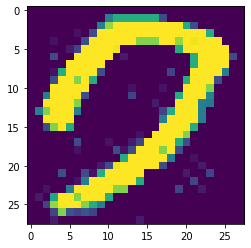

In [3]:
train_data = np.load("train.npz")
test_data = np.load("test.npz")


train_image = train_data['image']
train_label = to_one_hot(train_data['label'])
train_input = train_image.reshape(train_image.shape[0],-1)
plt.imshow(train_image[0])
print('label : ',train_label[0])


label :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


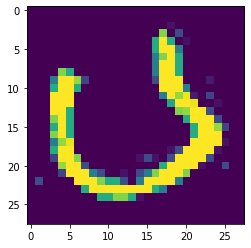

In [4]:
test_image = test_data['image']
test_label = to_one_hot(test_data['label'])
test_input = test_image.reshape(test_image.shape[0],-1)
plt.imshow(test_image[1])
print('label : ',test_label[1])


In [5]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def relu(z):
    return np.maximum(z,0)

def reluDerivative(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

In [6]:
#     cross entropy
def loss(y, y_hat):
    y = y.T
    l_sum = np.sum(np.multiply(y, np.log(y_hat)))
    batch_num = y.shape[1]
    l = -(1./batch_num) * l_sum
    return l


In [7]:
def forward(x, theta):
    x = x.T
    tmp = {}
    
    tmp["z1"] = np.matmul(theta['w1'],x) + theta['b1']
    tmp['a1'] = sigmoid(tmp['z1'])
    
    tmp['z2'] = np.matmul(theta['w2'],tmp['a1']) + theta['b2']
    tmp['a2'] = tmp['z2']
    
    tmp['z3'] = np.matmul(theta['w3'],tmp['a2']) + theta['b3']
    #soft max
    tmp['a3'] = np.exp(tmp['z3']) / np.sum(np.exp(tmp['z3']),axis=0)
    
    return tmp


In [8]:
def backward(x,y,theta,tmp):
    x = x.T
    y = y.T
    b_size = x.shape[0]
    
    dz3 = tmp["a3"] - y
    dw3 = (1./b_size)*np.matmul(dz3, tmp['a2'].T)
    db3 = (1./b_size)*np.sum(dz3,axis=1,keepdims=True)
    
    da2 = np.matmul(theta['w3'].T,dz3)
    dz2 = da2
    dw2 = (1./b_size)*np.matmul(dz2, tmp['a1'].T)
    db2 = (1./b_size)*np.sum(dz2,axis=1,keepdims=True)
    
    da1 = np.matmul(theta['w2'].T,dz2)
    dz1 = da1 * sigmoid(tmp['z1']) * (1 - sigmoid(tmp['z1']))
    dw1 = (1./b_size)*np.matmul(dz1, x.T)
    db1 = (1./b_size)*np.sum(dz1,axis=1,keepdims=True)

    gradients = {'dw1':dw1, 'db1':db1, 'dw2':dw2, 'db2':db2, 'dw3':dw3, 'db3':db3}
    
    return gradients

In [9]:
def error_rate(y, y_hat):
    y_hat = y_hat.T
    r = 0
    y_ans = np.argmax(y,axis=1)
    y_hat_ans = np.argmax(y_hat,axis=1)
    w = np.count_nonzero(y_ans-y_hat_ans)
    return w/float(y.shape[0])
    

In [10]:
learning_rate = 0.4
epochs = 1000

input_shape = train_input.shape[1]
output_shape = 10
n_hidden1 = 64
n_hidden2 = 2
batch_size = 60

theta = {"w1": np.random.randn(n_hidden1, input_shape) * np.sqrt(1. / input_shape),
          "b1": np.zeros((n_hidden1, 1)) * np.sqrt(1. / input_shape),
          "w2": np.random.randn(n_hidden2, n_hidden1) * np.sqrt(1. / n_hidden1),
          "b2": np.zeros((n_hidden2, 1)) * np.sqrt(1. / n_hidden2),
          "w3": np.random.randn(output_shape, n_hidden2) * np.sqrt(1. / output_shape),
          "b3": np.zeros((output_shape, 1))}

# theta = {"w1": np.zeros((n_hidden1, input_shape)),
#           "b1": np.zeros((n_hidden1, 1)),
#           "w2": np.zeros((n_hidden2,n_hidden1)),
#           "b2": np.zeros((n_hidden2,1)),
#           "w3": np.zeros((output_shape, n_hidden2)),
#           "b3": np.zeros((output_shape, 1))}

print(theta['w1'].shape)
print(theta['b1'].shape)
print(theta['w2'].shape)
print(theta['b2'].shape)
print(theta['w3'].shape)
print(theta['b3'].shape)




(64, 784)
(64, 1)
(2, 64)
(2, 1)
(10, 2)
(10, 1)


Epoch 1000: training loss = 0.3719, test error = 0.1255, train error = 0.1086 


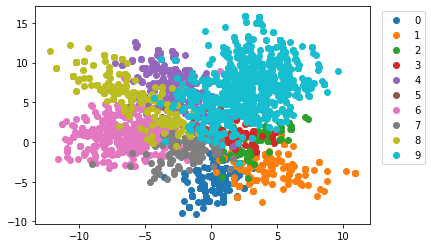

In [11]:
train_losses = []
train_errors = []
test_errors = []

for i in range(epochs):

    permutation = np.random.permutation(train_input.shape[0])
    train_x = train_input[permutation,: ].reshape(-1,batch_size,train_input.shape[1])
    train_y = train_label[permutation,: ].reshape(-1,batch_size,train_label.shape[1])
    
    for idx,(x,y) in enumerate(zip(train_x,train_y)):
        
        tmp = forward(x, theta)
        gradients = backward(x, y, theta, tmp)

        # apply gradient
        theta["w1"] = theta["w1"] - learning_rate * gradients['dw1']
        theta["b1"] = theta["b1"] - learning_rate * gradients['db1']
        theta["w2"] = theta["w2"] - learning_rate * gradients['dw2']
        theta["b2"] = theta["b2"] - learning_rate * gradients['db2']
        theta["w3"] = theta["w3"] - learning_rate * gradients['dw3']
        theta["b3"] = theta["b3"] - learning_rate * gradients['db3']

    # training loss
    tmp = forward(train_input, theta)
    train_loss = loss(train_label, tmp["a3"])
    train_feature = tmp['a2']
    train_error = error_rate(train_label, tmp["a3"])

    # test loss
    tmp = forward(test_input, theta)
    test_error = error_rate(test_label, tmp["a3"])
    test_feature = tmp['a2']
    

    print("Epoch {:3}: training loss = {:.4f}, test error = {:.4f}, train error = {:.4f} ".format(
        i + 1, train_loss, test_error, train_error))

    train_losses.append(train_loss)
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    data = pd.DataFrame({"x": train_feature[0], "y": train_feature[1], "label": train_data['label'].astype('int32')})

    
    groups = data.groupby("label")
    for name, group in groups:
        plt.plot(group["x"], group["y"], marker="o", linestyle="", label=name)
    plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
    plt.show()

    
    clear_output(wait=True)

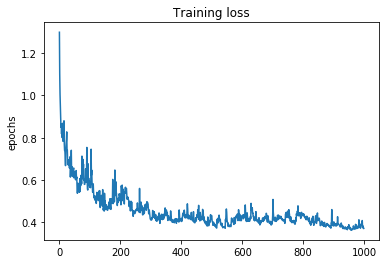

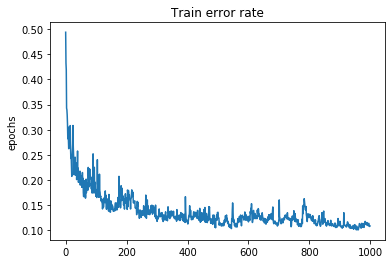

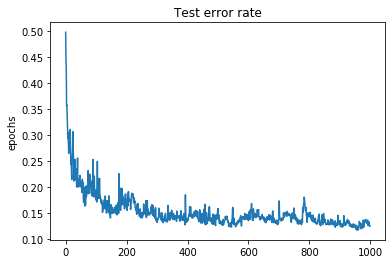

In [12]:
plt.plot(train_losses)
plt.ylabel('average cross entropy')
plt.ylabel('epochs')
plt.title('Training loss')
plt.show()


plt.plot(train_errors)
plt.ylabel('error rate')
plt.ylabel('epochs')
plt.title('Train error rate')    
plt.show()

plt.plot(test_errors)
plt.ylabel('error rate')
plt.ylabel('epochs')
plt.title('Test error rate')    
plt.show()

/home/ray/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


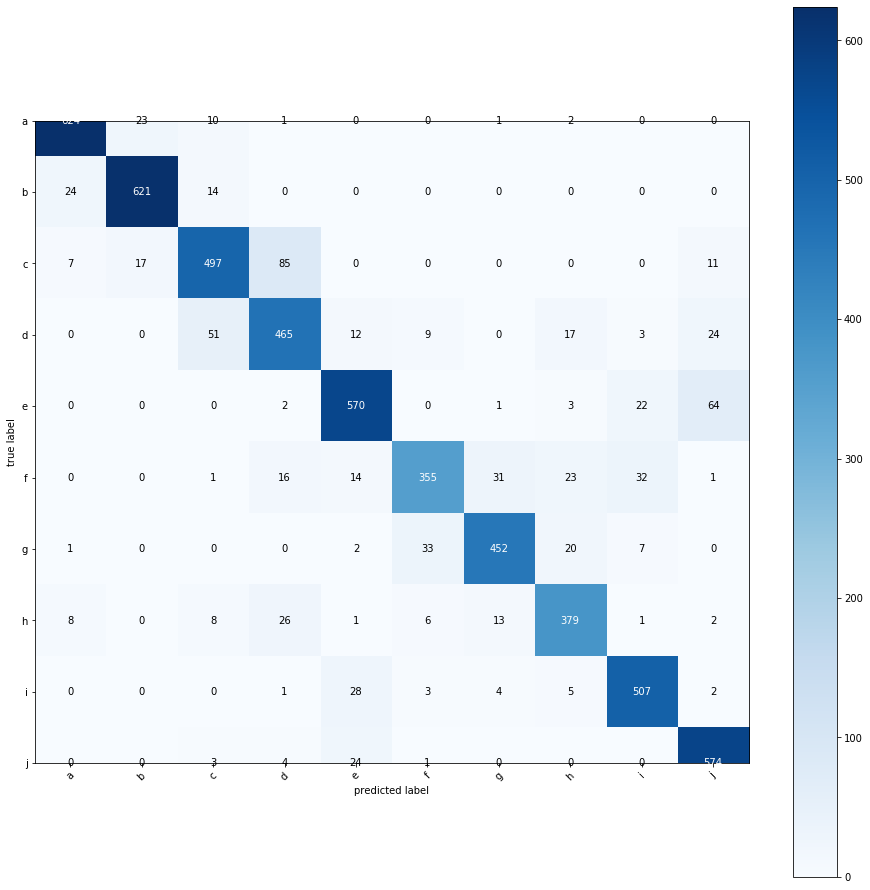

In [43]:
tmp = forward(test_input, theta)
y_pred = np.argmax(tmp['a3'],axis=0)
y_true = test_data['label']
cf_mat = confusion_matrix(y_pred,y_true)

fig, ax = plot_confusion_matrix(cf_mat,figsize=(16,16),colorbar=True,class_names=class_names)
plt.show()